# Introduction to scikit-learn

## Basic preprocessing and model fitting

In this notebook, we present how to build predictive models on tabular
datasets.

In particular we will highlight:
* the difference between numerical and categorical variables;
* the importance of scaling numerical variables;
* typical ways to deal categorical variables;
* train predictive models on different kinds of data;
* evaluate the performance of a model via cross-validation.

## Introducing the dataset

To this aim, we will use data from the 1994 Census bureau database. The goal
with this data is to regress wages from heterogeneous data such as age,
employment, education, family information, etc.

Let's first load the data located in the `datasets` folder.

In [1]:
import pandas as pd

df = pd.read_csv(
    "https://www.openml.org/data/get_csv/1595261/adult-census.csv")

# Or use the local copy:
# df = pd.read_csv('../datasets/adult-census.csv')

Let's have a look at the first records of this data frame:

In [2]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


The target variable in our study will be the "class" column while we will use
the other columns as input variables for our model. This target column divides
the samples (also known as records) into two groups: high income (>50K) vs low
income (<=50K). The resulting prediction problem is therefore a binary
classification problem.

For simplicity, we will ignore the "fnlwgt" (final weight) column that was
crafted by the creators of the dataset when sampling the dataset to be
representative of the full census database.

In [3]:
target_name = "class"
target = df[target_name].to_numpy()
target

array([' <=50K', ' <=50K', ' >50K', ..., ' <=50K', ' <=50K', ' >50K'],
      dtype=object)

In [4]:
data = df.drop(columns=[target_name, "fnlwgt"])
data.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


We can check the number of samples and the number of features available in
the dataset:

In [5]:
print(
    f"The dataset contains {data.shape[0]} samples and {data.shape[1]} "
    "features")

The dataset contains 48842 samples and 13 features


## Working with numerical data

The numerical data is the most natural type of data used in machine learning
and can (almost) directly be fed to predictive models. We can quickly have a
look at such data by selecting the subset of columns from the original data.

We will use this subset of data to fit a linear classification model to
predict the income class.

In [6]:
data.columns

Index(['age', 'workclass', 'education', 'education-num', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [7]:
data.dtypes

age                int64
workclass         object
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
dtype: object

In [8]:
numerical_columns = [
    c for c in data.columns if data[c].dtype.kind in ["i", "f"]]
numerical_columns

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [9]:
data_numeric = data[numerical_columns]
data_numeric.head()

,age,education-num,capital-gain,capital-loss,hours-per-week
0,25,7,0,0,40
1,38,9,0,0,50
2,28,12,0,0,40
3,44,10,7688,0,40
4,18,10,0,0,30


When building a machine learning model, it is important to leave out a
subset of the data which we can use later to evaluate the trained model.
The data used to fit a model a called training data while the one used to
assess a model are called testing data.

Scikit-learn provides an helper function `train_test_split` which will
split the dataset into a training and a testing set. It will ensure that
the data are shuffled randomly before splitting the data.

In [10]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data_numeric, target, random_state=42)

print(
    f"The training dataset contains {data_train.shape[0]} samples and "
    f"{data_train.shape[1]} features")
print(
    f"The testing dataset contains {data_test.shape[0]} samples and "
    f"{data_test.shape[1]} features")

The training dataset contains 36631 samples and 5 features
The testing dataset contains 12211 samples and 5 features


We will build a linear classification model called "Logistic Regression". The
`fit` method is called to train the model from the input and target data. Only
the training data should be given for this purpose.

In addition, when checking the time required to train the model and internally
check the number of iterations done by the solver to find a solution.

In [11]:
from sklearn.linear_model import LogisticRegression
import time

model = LogisticRegression(solver='lbfgs')
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

print(f"The model {model.__class__.__name__} was trained in "
      f"{elapsed_time:.3f} seconds for {model.n_iter_} iterations")

The model LogisticRegression was trained in 0.463 seconds for [100] iterations


/home/lemaitre/Documents/code/toolbox/scikit-learn/sklearn/linear_model/logistic.py:932: ConvergenceWarning: lbfgs failed to converge (status=1): b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'. Increase the number of iterations.
  n_iter_i = _check_optimize_result(solver, opt_res, max_iter)


Let's ignore the convergence warning for now and instead let's try
to use our model to make some predictions on the first three records
of the held out test set:

In [12]:
target_predicted = model.predict(data_test)
target_predicted[:5]

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' <=50K'], dtype=object)

In [13]:
target_test[:5]

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' <=50K'], dtype=object)

In [14]:
predictions = data_test.copy()
predictions['predicted-class'] = target_predicted
predictions['expected-class'] = target_test
predictions['correct'] = target_predicted == target_test
predictions.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,predicted-class,expected-class,correct
7762,56,9,0,0,40,<=50K,<=50K,True
23881,25,9,0,0,40,<=50K,<=50K,True
30507,43,13,14344,0,40,>50K,>50K,True
28911,32,9,0,0,40,<=50K,<=50K,True
19484,39,13,0,0,30,<=50K,<=50K,True


To quantitatively evaluate our model, we can use the method `score`. It will
compute the classification accuracy when dealing with a classificiation
problem.

In [15]:
print(f"The test accuracy using a {model.__class__.__name__} is "
      f"{model.score(data_test, target_test):.3f}")

The test accuracy using a LogisticRegression is 0.818


This is mathematically equivalent as computing the average number of time
the model makes a correct prediction on the test set:

In [16]:
(target_test == target_predicted).mean()

0.8177053476373761

## Exercise 1

- What would be the score of a model that always predicts `' >50K'`?
- What would be the score of a model that always predicts `' <= 50K'`?
- Is 81% or 82% accuracy a good score for this problem?

Hint: You can compute the cross-validated of a [DummyClassifier](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators) the performance of such baselines.

Use the dedicated notebook to do this exercise.

Let's now consider the `ConvergenceWarning` message that was raised previously
when calling the `fit` method to train our model. This warning informs us that
our model stopped learning becaused it reached the maximum number of
iterations allowed by the user. This could potentially be detrimental for the
model accuracy. We can follow the (bad) advice given in the warning message
and increase the maximum number of iterations allowed.

In [17]:
model = LogisticRegression(solver='lbfgs', max_iter=50000)
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

In [18]:
print(
    f"The accuracy using a {model.__class__.__name__} is "
    f"{model.score(data_test, target_test):.3f} with a fitting time of "
    f"{elapsed_time:.3f} seconds in {model.n_iter_} iterations")

The accuracy using a LogisticRegression is 0.818 with a fitting time of 0.417 seconds in [105] iterations


We can observe now a longer training time but not significant improvement in
the predictive performance. Instead of increasing the number of iterations, we
can try to help fit the model faster by scaling the data first. A range of
preprocessing algorithms in scikit-learn allows to transform the input data
before training a model. We can easily combine these sequential operation with
a scikit-learn `Pipeline` which will chain the operations and can be used as
any other classifier or regressor. The helper function `make_pipeline` will
create a `Pipeline` by giving the successive transformations to perform.

In our case, we will standardize the data and then train a new logistic
regression model on that new version of the dataset set.

In [19]:
data_train.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,36631.000000,36631.000000,36631.000000,36631.000000,36631.000000
mean,38.642352,10.078131,1087.077721,89.665311,40.431247
std,13.725748,2.570143,7522.692939,407.110175,12.423952
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_train_scaled = scaler.fit_transform(data_train)
data_train_scaled

array([[ 0.17177061,  0.35868902, -0.14450843,  5.71188483, -2.28845333],
       [ 0.02605707,  1.1368665 , -0.14450843, -0.22025127, -0.27618374],
       [-0.33822677,  1.1368665 , -0.14450843, -0.22025127,  0.77019645],
       ...,
       [-0.77536738, -0.03039972, -0.14450843, -0.22025127, -0.03471139],
       [ 0.53605445,  0.35868902, -0.14450843, -0.22025127, -0.03471139],
       [ 1.48319243,  1.52595523, -0.14450843, -0.22025127, -2.69090725]])

In [21]:
data_train_scaled = pd.DataFrame(data_train_scaled,
                                 columns=data_train.columns)
data_train_scaled.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,3.663100e+04,3.663100e+04,3.663100e+04,3.663100e+04,3.663100e+04
mean,-2.273364e-16,1.219606e-16,3.530310e-17,3.840667e-17,1.844684e-16
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-1.576792e+00,-3.532198e+00,-1.445084e-01,-2.202513e-01,-3.173852e+00
25%,-7.753674e-01,-4.194885e-01,-1.445084e-01,-2.202513e-01,-3.471139e-02
50%,-1.196565e-01,-3.039972e-02,-1.445084e-01,-2.202513e-01,-3.471139e-02
75%,6.817680e-01,7.477778e-01,-1.445084e-01,-2.202513e-01,3.677425e-01
max,3.741752e+00,2.304133e+00,1.314865e+01,1.047970e+01,4.714245e+00


In [22]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='lbfgs'))
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

In [23]:
print(
    f"The accuracy using a {model.__class__.__name__} is "
    f"{model.score(data_test, target_test):.3f} with a fitting time of "
    f"{elapsed_time:.3f} seconds in {model[-1].n_iter_} iterations")

The accuracy using a Pipeline is 0.818 with a fitting time of 0.099 seconds in [13] iterations


We can see that the training time and the number of iterations is much shorter
while the predictive performance (accuracy) stays the same.

In the previous example, we split the original data into a training set and a
testing set. This strategy has several issues: in the setting where the amount
of data is limited, the subset of data used to train or test will be small;
and the splitting was done in a random manner and we have no information
regarding the confidence of the results obtained.

Instead, we can use what cross-validation. Cross-validation consists in
repeating this random splitting into training and testing sets and aggregate
the model performance. By repeating the experiment, one can get an estimate of
the variabilty of the model performance.

The function `cross_val_score` allows for such experimental protocol by giving
the model, the data and the target. Since there exists several
cross-validation strategies, `cross_val_score` takes a parameter `cv` which
defines the splitting strategy.








In [24]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, data_numeric, target, cv=5)
print(f"The different scores obtained are: \n{scores}")

The different scores obtained are: 
[0.81216092 0.8096018  0.81337019 0.81326781 0.82207207]


In [25]:
print(f"The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} +/- {scores.std():.3f}")

The mean cross-validation accuracy is: 0.814 +/- 0.004


Note that by computing the standard-deviation of the cross-validation scores
we can get an idea of the uncertainty of our estimation of the predictive
performance of the model: in the above results, only the first 2 decimals seem
to be trustworthy. Using a single train / test split would not allow us to
know anything about the level of uncertainty of the accuracy of the model.

Setting `cv=5` created 5 distinct splits to get 5 variations for the training
and testing sets. Each training set is used to fit one model which is then
scored on the matching test set. This strategy is called K-fold
cross-validation where `K` corresponds to the number of splits.

The following matplotlib code helps visualize how the datasets is partitionned
between train and test samples at each iteration of the cross-validation
procedure:

In [26]:
%matplotlib inline
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

cmap_cv = plt.cm.coolwarm


def plot_cv_indices(cv, X, y, ax, lw=20):
    """Create a sample plot for indices of a cross-validation object."""
    splits = list(cv.split(X=X, y=y))
    n_splits = len(splits)

    # Generate the training/testing visualizations for each CV split
    for ii, (train, test) in enumerate(splits):
        # Fill in indices with the training/test groups
        indices = np.zeros(shape=X.shape[0], dtype=np.int32)
        indices[train] = 1

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits + 2) + .5,
           yticklabels=yticklabels, xlabel='Sample index',
           ylabel="CV iteration", ylim=[n_splits + .2,
                                        -.2], xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

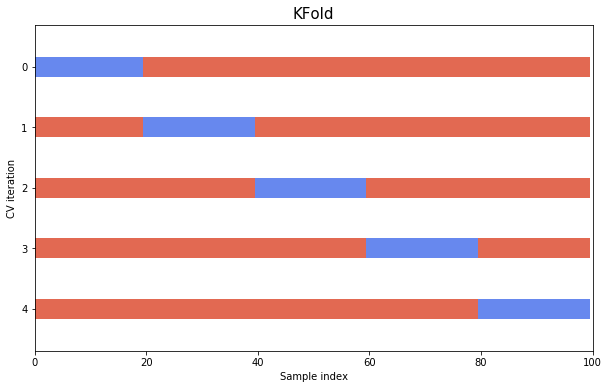

In [27]:
# Some random data points
n_points = 100
X = np.random.randn(n_points, 10)
y = np.random.randn(n_points)

fig, ax = plt.subplots(figsize=(10, 6))
cv = KFold(5)
plot_cv_indices(cv, X, y, ax)

# TODO: add summary here